# CS/ECE/ISyE 524 - Spr 2018 - HW 5 - Solutions
### Prepared by: Laurent Lessard

## 1. Spline fitting

We are running a series of experiments to evaluate the properties of a new 
uorescent material. As we vary the intensity of the incident light, the material should fluoresce
different amounts. Unfortunately, the material isn't perfectly uniform and our method for measuring

Fluorescence is not very accurate. After testing 200 different intensities, we obtained the result below
(also available in `xy_data.csv`). The intensities $x_i$ and 
uorescences $y_i$ are recorded in the first and second columns of the data matrix, respectively.

The material has interesting nonlinear properties, and we would like to characterize the relationship
between intensity and fluorescence by using an approximate model that agrees well with the trend of
our experimental data. Although there is noise in the data, we know from physics that the fluorescence
must be zero when the intensity is zero. This fact must be reflected in all of our models!

**a)** Polynomial fit. Find the best cubic polynomial fit to the data. In other words, look for a
function of the form $y = a_1x^3 + a_2x^2 + a_3x + a_4$ that has the best possible agreement with the
data. Remember that the model should have zero fluorescence when the intensity is zero! Include
a plot of the data along with your best-fit cubic on the same axes.

**b)** Spline fit. Instead of using a single cubic polynomial, we will look for a fit to the data using two
quadratic polynomials. Specifically, we want to find coeficients pi and qi so that our data is well
modeled by the piecewise quadratic function:
$$
y = \begin{cases}
p_1x^2 + p_2x + p_3 & \text{if }0 \le x < 4 \\
q_1x^2 + q_2x + q_3 & \text{if }4 \le x < 10
\end{cases}
$$

These quadratic functions must be designed so that:
* as in the cubic model, there is zero fluorescence when the intensity is zero.
* both quadratic pieces have the same value at $x = 4$.
* both quadratic pieces have the same slope at $x = 4$.
In other words, we are looking for a smooth piecewise quadratic. This is also known as a spline
(this is just one type of spline, there are many other types!). Include a plot of the data along with
your best-fit model.

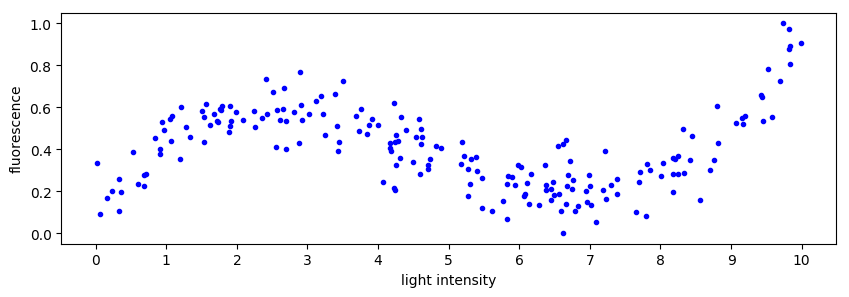

In [1]:
# plot the original data for the problem

A = readcsv("xy_data.csv")
x = A[:,1]
y = A[:,2]

using PyPlot
function plotpoints()
    figure(figsize=(10,3))
    plot(x,y,"b.")
    xlabel("light intensity")
    ylabel("fluorescence")
    xticks(0:10)
end
   
plotpoints()
;

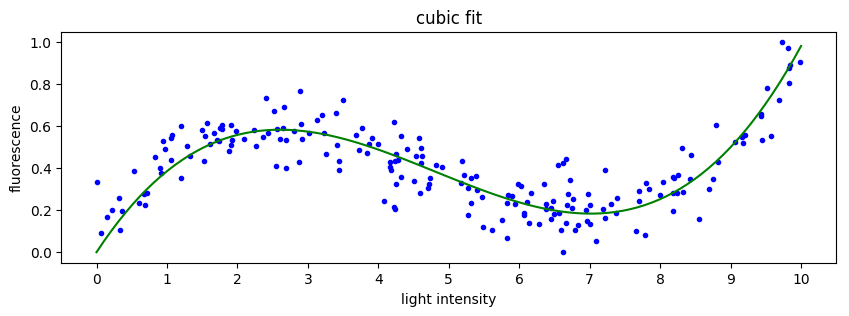

In [2]:
# solve the first part; cubic fit (this is just a least squares problem!)

n = length(x)
Amat = [x.^3 x.^2 x]   # cubic of the form y = ax^3+bx^2+cx (no constant term so that y(0)=0)
w = Amat\y;

plotpoints()
xvals = linspace(0,10,100)
yvals = w[1]*xvals.^3 + w[2]*xvals.^2 + w[3]*xvals
plot(xvals,yvals,"g-")
title("cubic fit")
;

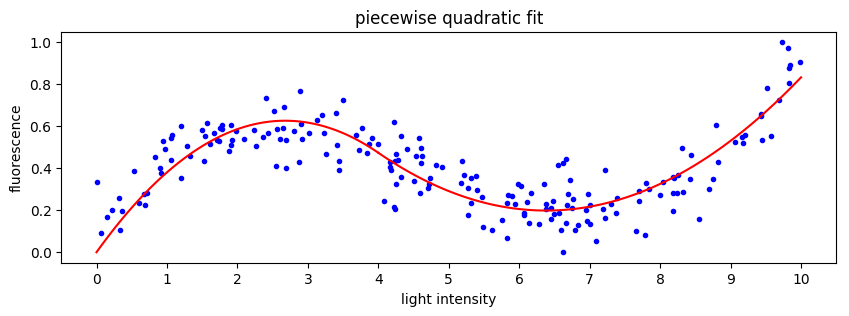

Academic license - for non-commercial use only


In [9]:
# solve the second part; piecewise quadratic (this is a QP)

indlo = find(x .< 4)
xlo = x[indlo]
ylo = y[indlo]

indhi = find(x .>= 4)
xhi = x[indhi]
yhi = y[indhi]

using JuMP, Gurobi

m = Model(solver = GurobiSolver(OutputFlag=0))

@variable(m,p[1:3])  # first segment
@variable(m,q[1:3])  # second segment

@constraint(m, p[3] == 0 )                                             # passes through the origin
@constraint(m, 4^2*p[1] + 4*p[2] + p[3] == 4^2*q[1] + 4*q[2] + q[3])   # function values match at x=4
@constraint(m, 2*4*p[1] + p[2] == 2*4*q[1] + q[2])                     # derivatives match at x=4

@expression(m, rlo, p[1]*xlo.^2 + p[2]*xlo + p[3] - ylo)   # residual for the first part
@expression(m, rhi, q[1]*xhi.^2 + q[2]*xhi + q[3] - yhi)   # residual for the second part

@objective(m, Min, sum(rlo.^2) + sum(rhi.^2))

solve(m)

xlovals = linspace(0,4,100)
popt = getvalue(p)
ylovals = popt[1]*xlovals.^2 + popt[2]*xlovals + popt[3]
xhivals = linspace(4,10,100)
qopt = getvalue(q)
yhivals = qopt[1]*xhivals.^2 + qopt[2]*xhivals + qopt[3]

plotpoints()
plot(xlovals,ylovals,"r-")
plot(xhivals,yhivals,"r-")
title("piecewise quadratic fit")
;

## 2. Moving averages

There are many ways to model the relationship between an input sequence
$\{u_1, u_2,\dots\}$ and an output sequence $\{y_1, y_2,\dots\}$. In class, we saw the moving average (MA) model,
where each output is approximated by a linear combination of the k most recent inputs:

$$
\text{MA:}\quad y_t ≈ b_1u_t + b_2u_{t−1} + \dots + b_ku_{t−k+1}
$$

We then used least-squares to find the coefficients $b_1,\dots, b_k$. What if we didn’t have access to the
inputs at all, and we were asked to predict future y values based only on the previous y values? One
way to do this is by using an autoregressive (AR) model, where each output is approximated by a
linear combination of the $\ell$ most recent outputs (excluding the present one):

$$
\text{AR:}\quad y_t ≈ a_1y_{t−1} + a_2y_{t−2} + \dots + a_\ell y_{t−\ell}
$$

Of course, if the inputs contain pertinent information, we shouldn’t expect the AR method to outperform
the MA method!

**a)** Using the same dataset from class `uy_data.csv`, plot the true y, and on the same axes, also plot
the estimated $\hat y$ using the MA model and the estimated $\hat y$ using the AR model. Use $k = 5$ for
both models. To quantify the difference between estimates, also compute $\|y − \hat h\|$ for both cases.

**b)** Yet another possible modeling choice is to combine both AR and MA. Unsurprisingly, this is
called the autoregressive moving average (ARMA) model:

$$
\text{ARMA:}\quad y_t ≈ a_1y_{t−1} + a_2y_{t−2} + \dots + a_\ell y_{t−\ell} + b_1u_t + b_2u_{t−1} + \dots + b_ku_{t−k+1}
$$

Solve the problem once more, this time using an ARMA model with $k = \ell = 1$. Plot $y$ and $\hat y$ as
before, and also compute the error $\|y − \hat y\|$.

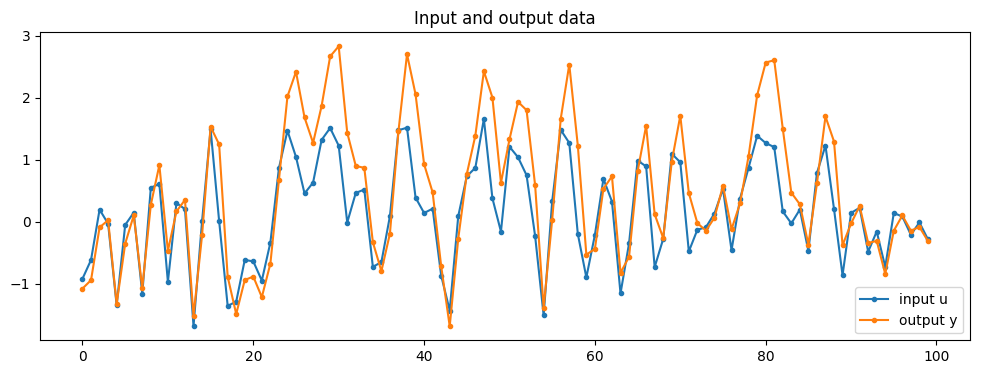

In [10]:
# Load the data file (ref: Boyd/263)
raw = readcsv("uy_data.csv");
u = raw[:,1];
y = raw[:,2];
T = length(u)

# plot the u and y data
using PyPlot
PyPlot.svg(true)

figure(figsize=(12,4))
plot([u y],".-");
legend(["input u", "output y"], loc="lower right");
title("Input and output data");

The norm of the error using MA is: 2.460854388269911


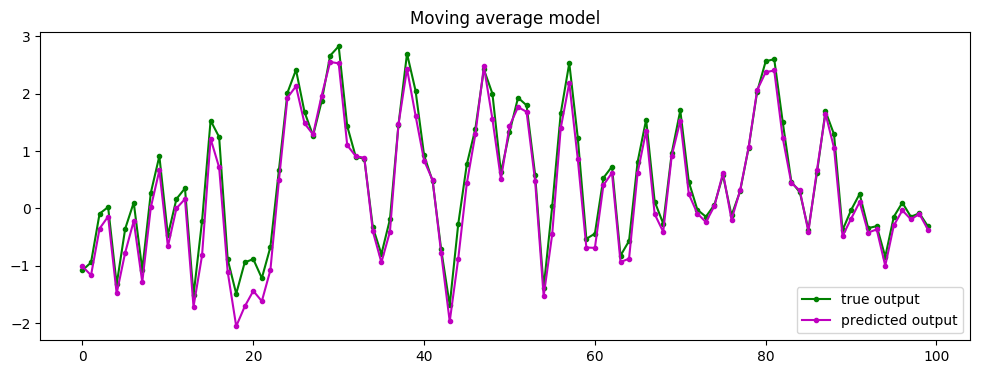

In [11]:
# generate A matrix. Using more width creates better fit.  (MA model)
width = 5
A = zeros(T,width)
for i = 1:width
    A[i:end,i] = u[1:end-i+1]
end
wopt = A\y
yest = A*wopt

println("The norm of the error using MA is: ",norm(yest-y))
sleep(.5)
figure(figsize=(12,4))
plot(y,"g.-",yest,"m.-")
legend(["true output", "predicted output"], loc="lower right");
title("Moving average model");

The norm of the error using AR is: 7.436691765656793


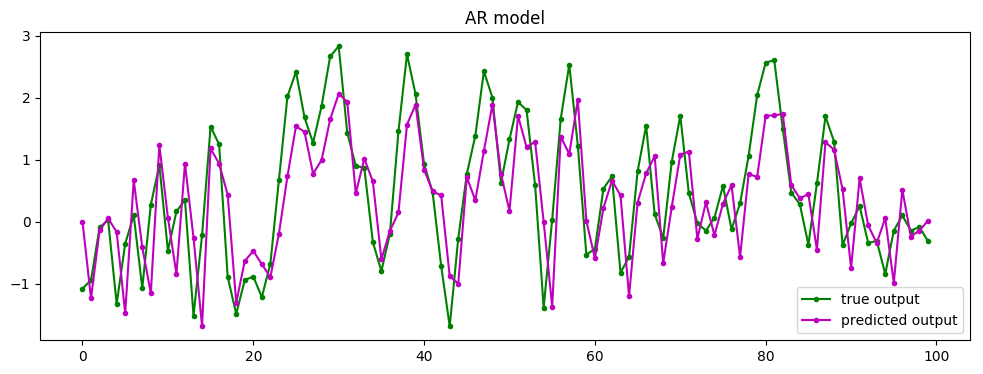

In [12]:
# generate A matrix. Using more width creates better fit.  (AR model)
width = 5
A = zeros(T,width)
for i = 1:width
    A[i+1:end,i] = y[1:end-i]
end
wopt = A\y
yest = A*wopt

println("The norm of the error using AR is: ",norm(yest-y))
sleep(.5)
figure(figsize=(12,4))
plot(y,"g.-",yest,"m.-")
legend(["true output", "predicted output"], loc="lower right");
title("AR model");

The norm of the error using ARMA is: 1.8565828148734604


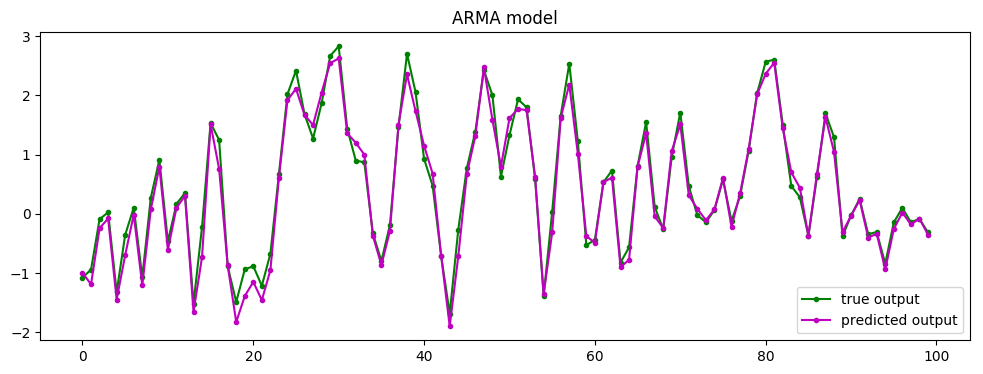

In [14]:
# generate A matrix. Using more width creates better fit.  (ARMA model)
w1 = 1; w2 = 1;
A = zeros(T,w1+w2)
for i = 1:w1
    A[i:end,i] = u[1:end-i+1]
end
for i = 1:w2
    A[i+1:end,w1+i] = y[1:end-i]
end
wopt = A\y
yest = A*wopt

println("The norm of the error using ARMA is: ",norm(yest-y))
sleep(.5)
figure(figsize=(12,4))
plot(y,"g.-",yest,"m.-")
legend(["true output", "predicted output"], loc="lower right");
title("ARMA model");

## 3. Hovercraft rendezvous

Alice and Bob are cruising on Lake Mendota in their  hovercrafts. Each hovercraft has the following dynamics: 
$$
\text{Dynamics of each hovercraft:}\qquad
\begin{aligned}
x_{t+1} &= x_t + \tfrac{1}{3600} v_t \\
v_{t+1} &= v_t + u_t
\end{aligned}
$$
At time $t$ (in seconds), $x_t \in \mathbb{R}^2$ is the position (in miles), $v_t \in \mathbb{R}^2$ is the velocity (in miles per hour), and $u_t \in \mathbb{R}^2$ is the thrust in normalized units. At $t=1$, Alice has a speed of 20~mph going North, and Bob is located half a mile East of Alice, moving due East at 30~mph. Alice and Bob would like to rendezvous at $t=60$ seconds. The location at which they meet is not important, but the time is!

**a)** Find the sequence of thruster inputs for Alice ($u^A$) and Bob ($u^B$) that achieves a rendezvous at $t=60$ while minimizing the total energy used by both hovercraft:
$$
\text{total energy} = \sum_{t=1}^{60} \left\|u_t^A\right\|^2 + \sum_{t=1}^{60} \left\|u_t^B\right\|^2
$$
Plot the trajectories of each hovercraft to verify that they do indeed rendezvous.

**b)** In addition to arriving at the same place at the same time, Alice and Bob should also make sure their velocities match when they rendezvous. If not, they might crash into each other! Solve the rendezvous problem again with the additional velocity matching constraint and plot the resulting trajectories. Is the optimal rendezvous location different from the one found in the first part?

**c)** Alice and Bob forgot about one important detail. The hovercrafts each have a top speed of 35~mph. The solutions found in the previous parts are unacceptable because they require Alice to exceed the maximum allowable speed. First, verify that this is indeed the case. Second, explain how to alter your model to account for the speed limit. Finally, solve the rendezvous problem one last time with all the constraints in place and verify that your solution respects the speed limit.

In [24]:
#PART A: Meet somewhere and minimize energy

using JuMP, Gurobi

st = 60 # stop time point

m = Model(solver=GurobiSolver(OutputFlag=0))

@variable(m, A_x[1:2, 1:st]) # position of Alice
@variable(m, A_v[1:2, 1:st]) # velocity
@variable(m, A_u[1:2, 1:st]) # thrust

@variable(m, B_x[1:2, 1:st]) # position of Bob
@variable(m, B_v[1:2, 1:st]) # velocity
@variable(m, B_u[1:2, 1:st]) # thrust

# initial
@constraint(m, A_x[:, 1] .== [0, 0])   # let's put A at the origin
@constraint(m, B_x[:, 1] .== [0.5, 0]) # B is half a mile east of A
@constraint(m, A_v[:, 1] .== [0, 20])  # A is moving North at 20 mph
@constraint(m, B_v[:, 1] .== [30, 0])  # B is moving East at 30 mph

# Dynamics
for i = 2:st
    @constraint(m, A_x[:, i] .== A_x[:, i-1] + A_v[:, i-1]/3600)
    @constraint(m, B_x[:, i] .== B_x[:, i-1] + B_v[:, i-1]/3600)
    @constraint(m, A_v[:, i] .== A_v[:, i-1] + A_u[:, i-1])
    @constraint(m, B_v[:, i] .== B_v[:, i-1] + B_u[:, i-1])
end

# meet at the given time.
@constraint(m, A_x[:, st] .== B_x[:, st])

@objective(m, Min, sum(A_u.^2) + sum(B_u.^2))

solve(m)

println("The minimum energy is ",getobjectivevalue(m))

Academic license - for non-commercial use only
The minimum energy is 105.9307047910204


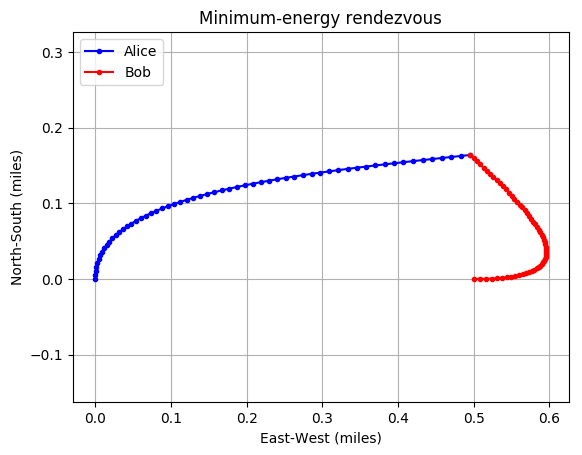

In [25]:
using PyPlot

plot(getvalue(A_x[1,:]), getvalue(A_x[2,:]),"b.-", label = "Alice")
plot(getvalue(B_x[1,:]), getvalue(B_x[2,:]),"r.-", label = "Bob")
xlabel("East-West (miles)")
ylabel("North-South (miles)")
legend(loc = "upper left")
grid()
axis("equal")
title("Minimum-energy rendezvous");

In [26]:
#PART B: Meet somewhere, match velocity, and minimize energy

# we can keep the same model as before. We only need to add one more constraint:
@constraint(m, A_v[:, st] .== B_v[:, st])   # extra constraint: match velocities!

solve(m)
println("The minimum energy is ",getobjectivevalue(m))

The minimum energy is 234.57042665108122


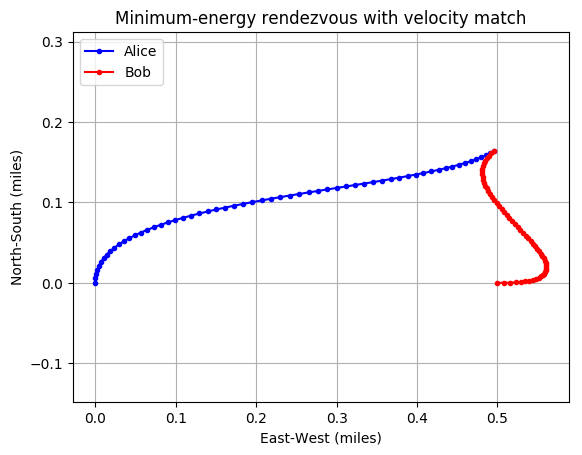

In [27]:
plot(getvalue(A_x[1,:]), getvalue(A_x[2,:]),"b.-", label = "Alice")
plot(getvalue(B_x[1,:]), getvalue(B_x[2,:]),"r.-", label = "Bob")
xlabel("East-West (miles)")
ylabel("North-South (miles)")
legend(loc = "upper left")
grid()
axis("equal")
title("Minimum-energy rendezvous with velocity match");